<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Multilabel Classification

In this notebook, we will look at the best practices for doing multilabel classification. 

In the previous notebook, we performed multi-class/single-label classification, where each image is assigned to only one label. For single-label classification, a picture of a single animal can be either an dog or a cat but not both at the same time. For multi-label classification each image can contain or represent multiple different labels: a landscape can be labeled both gloomy (weather) and of a beach (subject).

In this notebook, we'll train a multilabel classifier and examine how best to structure data for multilabel classification problems as well as learn about new ways to evaluate our results. 

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai and other libraries needed. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [2]:
import sys
sys.path.append("../../")

import warnings
warnings.filterwarnings('ignore')

import inspect
import numpy as np
import pandas as pd
from pathlib import Path

# fastai and torch
import fastai
from fastai.vision import *

# local modules
from utils_cv.classification.model import (
    TrainMetricsRecorder, hamming_score, zero_one_score, get_optimal_threshold,
)
from utils_cv.classification.plot import plot_pr_roc_curves, plot_thresholds
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla V100-PCIE-16GB
Available / Total memory = 14988 / 16130 (MiB)


Like before, we set some parameters. This time, we can use one of the multilabel datasets that comes with this repo.

In [3]:
DATA_PATH     = unzip_url(Urls.multilabel_fridge_objects_path, exist_ok=True)
EPOCHS        = 10
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

---

## 1. Preparing Image Data for Multilabel Classification

In this notebook, we'll look at different kinds of beverages. In the repo, under `data`, we've downloaded a directory titled: __multilabelFridgeObjects__.

Lets set that directory to our `path` variable, which we'll use throughout the notebook. We'll also inspect what's inside to get an understanding of how to structure images for multilabel classification.

In [4]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/models'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/labels.csv'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images')]

Lets inspect the `/images` folder:

In [5]:
(path/'images').ls()[:5]

[PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/16.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/98.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/66.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/76.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/33.jpg')]

Lets also take a look at the `labels.csv` file using pandas. 

In [6]:
df = pd.read_csv(path/'labels.csv'); df.sample(5)

,filename,labels
77,78.jpg,carton can milk_bottle water_bottle
117,118.jpg,water_bottle milk_bottle
66,67.jpg,carton can milk_bottle water_bottle
42,43.jpg,water_bottle carton milk_bottle
53,54.jpg,carton can milk_bottle


As shown above, the contents of the csv file is a mapping of the filename to the labels. Since this is a multilabel classificaiton problem, each image can be associated to multiple labels.

This is one of the most common data formast for multilabel image classification; one csv file that contains the mapping of labels to a folder of images:

```
/images
+-- labels.csv
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
|   +-- image131.jpg
|   +-- image132.jpg
```

## 2. Load labels and images

__Loading data__

Now that we know the structure of our data, lets use fast.ai's data block apis to create our databunches so that we can easily load mini-batches of data from our filesystem into our trainer.

In [7]:
np.random.seed(42)
data = (ImageList.from_csv(path, 'labels.csv', folder='images')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' ')
       .transform(size=299)
       .databunch(bs=32)
       .normalize(imagenet_stats))

Lets break down the code:

The first thing we need to do is to create an `ImageList`, and we'll do so by creating it from a csv file (`from_csv`). Then we want to do a random split (`random_split_by_pct`) so that we have our validation set. For this method, we've also set a random seed (`np.random.seed(42)`) so that our validation set is consistent. Finally we want to get our labels from the df (`label_from_df`) that comes from the csv file. Since our labels are space-seperated in the csv file, we want to specify that our labels will be delimited by a space (`label_delim=' '`). 

In the second part, we use the `ImageList` we created and apply a transformation on it (`transform`) so that all images are resized to 299X299. Then we turn it into a databunch, which is basically the kind of object fastai's trainer uses to load mini-batches of data. Finally we'll normalize the databunch (`normalize(imagenet_states)` to the imagenet parameters.

__Inpsect data__

To make sure our data is correctly loaded, lets print out the number of classes, and each of the class labels.

In [8]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


We can also call `batch_stats` on our databunch object to get a view on how the data is split between training and validation.

In [9]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton,milk_bottle,can,water_bottle,can
Path: /home/jiata/code/cvbp/data/multilabelFridgeObjects;

Valid: LabelList (25 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton;can;milk_bottle,water_bottle;carton;milk_bottle,water_bottle;can,milk_bottle;water_bottle;can,can
Path: /home/jiata/code/cvbp/data/multilabelFridgeObjects;

Test: None>

Lets get a sample of what the data looks like.

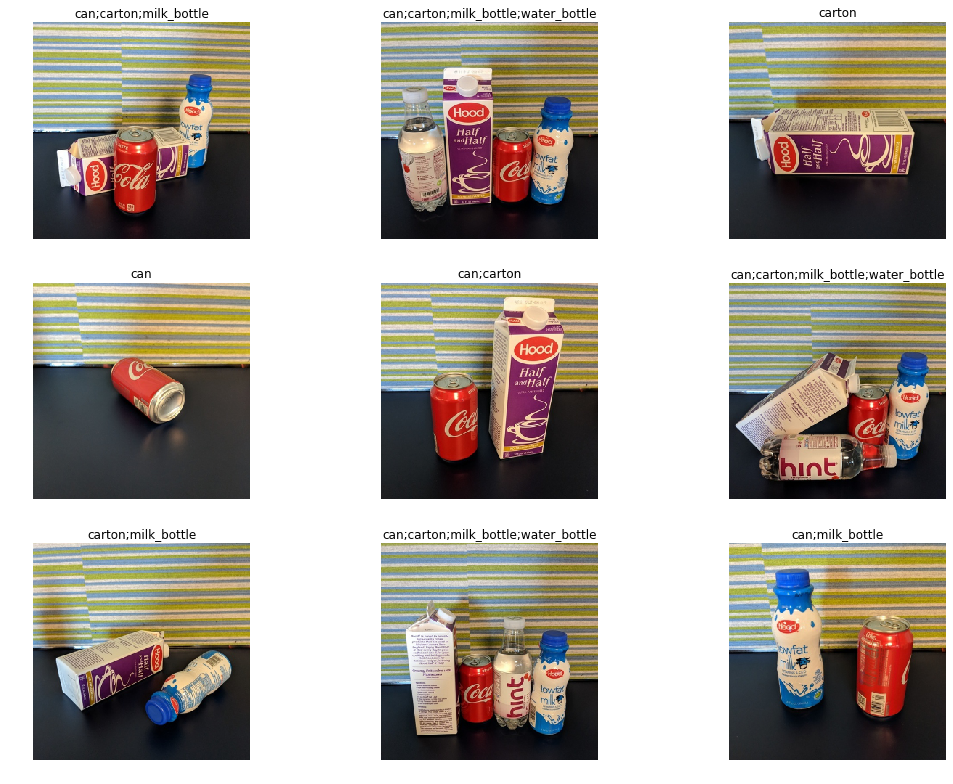

In [10]:
data.show_batch(rows=3, figsize=(15, 11))

# 3. Training our multilabel classifier

Two of the main differences between training a multilabel classifier an a single-label classifier is the _evaluation metric(s)_ we use to evaluate our model, and the _loss function_ we use to optimize it.

## Evaluation Metrics


__The Problem With Accuracy__

In traditional classification, accuracy is the most common evaluation criteria. For multilabel classification problems, a misclassification is not binary: right or wrong. Instead a prediction for an instance is a set of labels. A prediction containing a subset of the correct labels we're looking for can be better than one that contains none of them. For example, in an image that is labelled both 'rainy' and 'forest', it is usually better to predict one correct label than neither of the correct labels. However, sometimes we may still want to consider a prediction a misclassification unless all the labels are correctly predicted. For multilabel classification, the meaning of 'accuracy' can be ambiguous, so instead, we'll look at _hamming score_ and _zero-one score_.

__Hamming Score & Zero-one Score__

One of the most common ways to evaluate a multilabel classification problem is by using the __hamming score__, which we can think of as the fraction of wrong labels to the total number of labels. If there are 10 images and each image has 4 labels, there would be a total of 40 labels. So if our model classified 3 out of the total 40 labels incorrectly, the hamming score would be 3/40.

Zero-one score is a much harsher evaluation metric than hamming score. The zero-one score will classify an entire set of labels for a given sample incorrect if it does not entirely match the true set of labels. Hamming score is more forgiving since it penalizes only the individual labels themselves.

Lets look at these two metrics with a concrete example. Lets say our validation set contains 5 images, each with 4 labels, and the results looks as such:
```
+-------+------------------+------------------+------------------+------------------+
| Image |  y_true:         |  y_pred:         |  hamming_score:  |  zero_one_score: |
|-------+------------------+------------------+------------------+------------------+
| im_01 |  [[1, 0, 0, 1],  |  [[1, 0, 0, 0],  |  [[0, 0, 0, 1],  |  [[1],           |
| im_02 |   [1, 0, 1, 1],  |   [1, 1, 1, 1],  |   [0, 1, 0, 0],  |   [1],           |
| im_03 |   [0, 1, 0, 0],  |   [0, 1, 0, 0],  |   [0, 0, 0, 0],  |   [0],           |
| im_04 |   [0, 1, 1, 0],  |   [0, 1, 1, 0],  |   [0, 0, 0, 0],  |   [0],           |
| im_05 |   [1, 1, 0, 0]]  |   [1, 1, 1, 0]]  |   [0, 0, 1, 0]]  |   [1]]           |
+-------+------------------+------------------+------------------+------------------+
|                                             | = 3/20 incorrect | = 3/5 incorrect  |
+-------+------------------+------------------+------------------+------------------+
```
In this case, the predictions has 3 out of a total of 20 predictions that are not true, so the hamming score is __0.15__. While there are only 3 misclassified labels, each of the misclassifications happen on a different image. So for calculating the zero-one score, we end up with 3/5, or __0.6__. If we compare this to hamming score, we can see that it is a much less forgiving metric.


While hamming score and zero-one score are a common evaluation metric for multilabel classification, note that it may not be ideal for all multilabel classification problems. For each problem, you need to assess what you're evaluating your model against to see if it is a good fit. 

## Loss Function

Deciding on which loss function to use is one of the important differences between doing single-label vs multilabel classification.

__Softmax for Single-label Classification__

For single-label multiclass classification, one of the most common ways to optimize our model is with [cross entropy loss](https://pytorch.org/docs/0.3.0/nn.html#crossentropyloss) which uses a softmax function to give a probability distribution around the n possible classes. This allows us to express a dependency across the labels; if the picture is likely of a _dog_, then it is unlikely of a _cat_. In fact, fastai automatically uses the cross entropy loss function when it detects, from your databunch, that your dataset has multiple classes and each image only has one correct label, ie multiclass/single-label classification. 

For example, lets say we're trying to predict which animal a given image is of. In this example, we pass the model  output values from the last layer of the network through a softmax function to get the joint probability distribution (notice it sums to 1) of the classes. To get our prediction, we simply use the highest probability, in this case, a horse.
```
+--------+---------------+---------+------------+
| labels | model_output  | softmax | prediction |
|--------+---------------+---------+------------+
| cat    | 1.6           |  0.086  | 0          |
| dog    | 0.4           |  0.026  | 0          |
| horse  | 3.9           |  0.864  | 1          |
| mouse  | 0.3           |  0.024  | 0          |
+--------+---------------+---------+------------+
```

__Sigmoid and a Threshold for Multilabel Classification__

A loss function that uses softmax doesn't work for multilabel classification. In single-label classification, by applying a softmax on the output, we get the joint-likelihood among the labels. However, for multilabel classification, label likelihoods are independent from each other; the likelihood of an image being _rainy_ is independent from the likelihood of it being a _forest_. Instead of the softmax function, we can use the sigmoid  function to normalize our result while preserving the independent relationship of each label.

For example, lets say we're trying to predict features of an scenic image. In this example, we pass the model output values from the last layer of the network through a sigmoid function to give us independent probabilities (notice they do _not_ sum to 1). Based on the set threshold, we can then make a prediction on a given label. In this case, we predict 'rainy', 'cloudy', and 'misty' since these labels pass the threshold of 0.5.
```
Threshold = 0.5
+-----------+---------------+---------+------------+
| labels    | model_output  | sigmoid | prediction |
|-----------+---------------+---------+------------+
| windy     | -1.2          | 0.231   | 0          |
| rainy     | 0.2           | 0.550   | 1          |
| cloudy    | 1.9           | 0.870   | 1          |
| sunny     | -0.3          | 0.426   | 0          |
| misty     | 3.4           | 0.968   | 1          |
+-----------+---------------+---------+------------+
```

---

This section that covers training a model with fastai is very similar to the previous notebook except for the evaluation metric and the loss function that is used.

Since this is a multilabel classification problem, we'll want to use hamming score and zero-one score, as our evalution metric. Unlike accuracy, fastai does not provide these metrics in their library, so we have to define them. To create our own metrics, we'll need to define a custom function that will takes `y_pred` and `y_true`, and returns a single metric. 

We've defined the hamming score and zero-one score functions in the `utils_cv.classification.models` module so we can use them directly when defining out `cnn_learner`. 

> To inspect the implementation of these functions, you can run:
> - `print(inspect.getsource(hamming_score))`
> - `print(inpsect.getsource(zero_one_score))`

In [11]:
learn = cnn_learner(
    data, 
    ARCHITECTURE, 
    metrics=[hamming_score, zero_one_score],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

You'll notice that we do not specify which loss function to use. This is because fastai uses the passed-in databunch to detect that this is a multilabel classification problem (that each x maps to a y that has multiple labels) and automatically sets the appropriate loss function. In this case, we see that fastai has chosen to use pytorch's [`BCEWithLogitsLoss`](https://pytorch.org/docs/0.3.0/nn.html#bcewithlogitsloss), which uses the sigmoid activation instead of a softmax.

For further details, we can inspect the loss function by calling `learn.loss_func??`.

In [12]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

We can not continue to train the model like we did in the previous notebook. Unfreeze our CNN since we're training all the layers.

In [13]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

epoch,train_loss,valid_loss,train_hamming_score,valid_hamming_score,train_zero_one_score,valid_zero_one_score,time
0,0.765335,0.760317,0.466146,0.540000,0.125000,0.920000,00:08
1,0.584297,0.660841,0.213542,0.430000,0.125000,0.920000,00:02
2,0.476673,0.599284,0.114583,0.390000,0.125000,0.880000,00:02
3,0.405840,0.532059,0.085938,0.320000,0.104167,0.840000,00:02
4,0.357882,0.464011,0.046875,0.270000,0.093750,0.840000,00:02
5,0.316104,0.421849,0.028646,0.230000,0.052083,0.720000,00:02
6,0.285912,0.386727,0.039062,0.190000,0.041667,0.600000,00:02
7,0.256629,0.340093,0.015625,0.170000,0.041667,0.520000,00:02
8,0.234032,0.304139,0.015625,0.140000,0.041667,0.480000,00:02
9,0.214274,0.276383,0.013021,0.120000,0.031250,0.400000,00:02


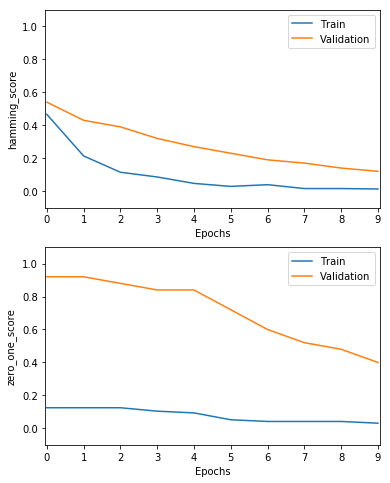

In [14]:
learn.fit(EPOCHS, LEARNING_RATE)

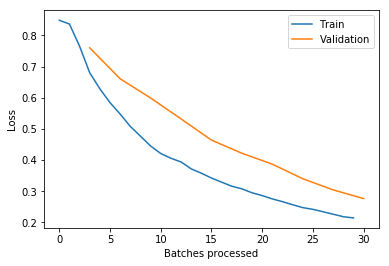

In [15]:
learn.recorder.plot_losses()

## 4. Evaluate the model

The learner comes with a handy function `show_results` that will show one mini-batch of the validation set. We can use that to get an intuitive sense of what is being predicted correctly and what is not.

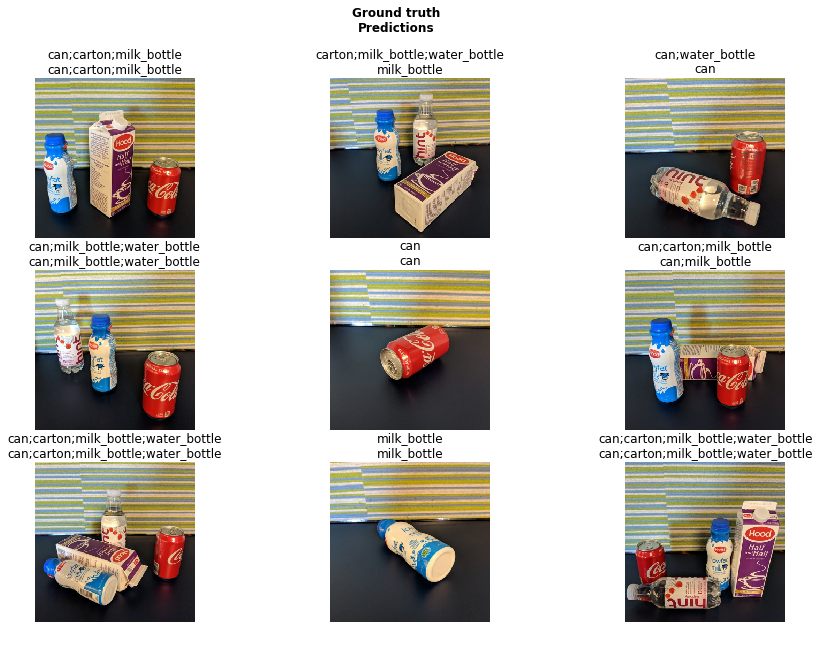

In [16]:
learn.show_results(rows=3, figsize=(15, 10))

To quantitatively evaluate our model, lets take a look at the hamming score and zero-one score on the validation set.

In [17]:
_, hl, zol = learn.validate(learn.data.valid_dl, metrics=[hamming_score, zero_one_score])
print(f'Hamming Score on validation set: {float(hl):3.2f}')
print(f'Zero-one Score on validation set: {float(zol):3.2f}')

Hamming Score on validation set: 0.12
Zero-one Score on validation set: 0.40


We've calculated the hamming score and the zero-one score on our validation set with the default probability threshold of 0.2. However, this default value may not be the most optimal value. We can use the `plot_thresholds` function to plot the evaluation metric at different levels of thresholds. If, for example, we were interested in the zero-one score, but we noticed that the default threshold is far from the minimum, we may consider using a different threshold when we perform inferencing. Lets plot the zero-one score at various thresholds to what the most optimal threshold is.

Note that the threshold represents a trade-off between specificity and sensitivity. The higher the threshold, the higher the _specificity_. The lower the threshold, the higher the _sensivity_.

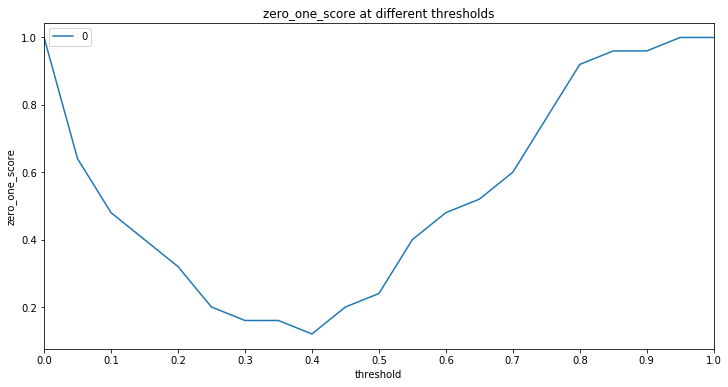

In [22]:
interp = learn.interpret()
plot_thresholds(zero_one_score, interp.probs, interp.y_true)

To get the threshold that will yield the best score for the metric we're using (hamming score or zero-one score), we've created a helper function that to do this: `get_optimal_threshold`. 

In [27]:
optimal_threshold = get_optimal_threshold(zero_one_score, interp.probs, interp.y_true)
optimal_threshold

0.4

With this threshold, we can then re-score our validation set using the zero_one_score evaluation metric function.

In [29]:
zero_one_score(interp.probs, interp.y_true, threshold=optimal_threshold)

tensor(0.1200)

# Conclusion
Multilabel classification different from traditional classification when it comes to how we organize and load our data, and when deciding on which evaluation metric(s) and loss function to use. 